In [2]:
import pandas as pd

## Frequently used aggregation functions in Pandas

Aggregation | Description
-----|-------
count() |	Total number of items
first(), last() |	First and last item
mean(), median() |	Mean and median
min(), max() |	Minimum and maximum
std(), var() |	Standard deviation and variance
mad() |	Mean absolute deviation
prod() |	Product of all items
sum() |	Sum of all items

In [3]:
# Create a DataFrame where some data is categorized as A, B, or C:
df = pd.DataFrame({"key": ['A', 'B', 'C', 'A', 'B', 'C'], 'data': range(6)})
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


In [4]:
# Previously, when we've wanted to view aggregations of the DataFrame,
# we've had to aggregate over all data at once. Here we are finding the
# mean of the entire "data" column:
df['data'].mean()

2.5

In [5]:
# What if we want the mean of a specific category? In this case,
# let's find the mean of all values only when it has the key "A":

df.loc[df['key'] == 'A', 'data'].mean()

1.5

In [6]:
# But what if I want the mean of all categories? In other words, I want
# to group my data by key (into "A", "B", and "C"), find the mean of each
# group individually, then output the results?
#
# We can try doing it ourselves with a combination of a for loop and several
# different calls to mean(). But this requires a lot of work on our part - can
# Pandas do this for us?
for i in ['A', 'B', 'C']:
  print(i, df.loc[df['key'] == i, 'data'].mean())

A 1.5
B 2.5
C 3.5


## The split-apply-combine process

To apply aggregations to groups of data, we can use Pandas's `groupby()` method and apply an aggregation to the group. Doing so engages the split-apply-combine process depicted below: by grouping on the "key" column in our dataset, Pandas will automatically split it into separate dataframes, one for each value of "key" (in this case, 3: one for "A", one for "B", and one for "C"). It will apply our specifed aggregation function to each split individually, then combine the results back into a single DataFrame listing the aggregation for each group. The process is depicted below:

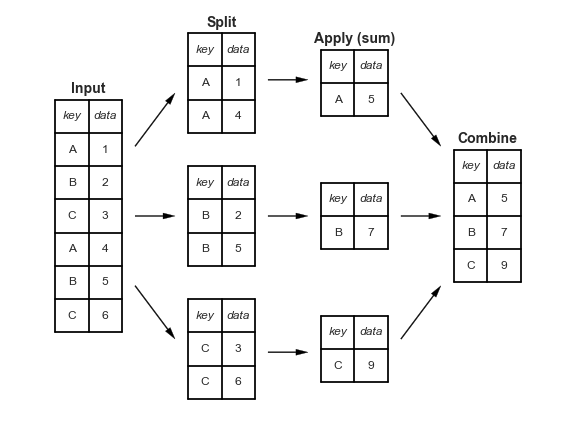

In [7]:
# We can kick off this process by calling "groupby()" on our DataFrame. Our argument
# to the groupby() function specifies which column we want to use to split our data.
#
# However, the output of this function is just a DataFrameGroupBy object - it can't
# do anything on its own until we specify an aggregation.
df.groupby('key')

In [8]:
# Here, we apply the mean() aggregation to the DataFrameGroupBy object.
# The result of this operation is a new DataFrame, showing the mean of each group.
df.groupby('key').mean()

,data
key,
A,1.5
B,2.5
C,3.5


In [9]:
# As a side note, the groupby function is iterative and can be used in for loops.
# If we want, we can loop over each group individually. However, this is uncommon
# in practice, and only done if complex, custom aggregations need to be performed
# on each group.
for k, v in df.groupby('key'):
  print(v)

  key  data
0   A     0
3   A     3
  key  data
1   B     1
4   B     4
  key  data
2   C     2
5   C     5


In [10]:
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


In [11]:
# We can also perform many aggregations at once over the same data.
# Here, we do this by calling the aggregate() function and passing a list
# of names of aggregations to apply.
#
# The list can contain strings corresponding to known aggregation functions or
# references to functions.
df.groupby('key').aggregate(['min', 'max', 'median', 'std', 'mean'])

data                         
     min max median      std mean
key                              
A      0   3    1.5  2.12132  1.5
B      1   4    2.5  2.12132  2.5
C      2   5    3.5  2.12132  3.5

In [12]:
# Note the above DataFrame has multi-index columns.
# This is because the aggregate() function will apply the same
# list of aggregations to all columns. The utility of the multi-index
# is visible on a DataFrame with multiple columns:

df2 = pd.DataFrame({
    "key": ['a', 'b', 'c', 'a', 'b', 'c'],
    'data1': range(6),
    'data2': [6, 2, 5, 1, 9, 0]
})
df2

,key,data1,data2
0,a,0,6
1,b,1,2
2,c,2,5
3,a,3,1
4,b,4,9
5,c,5,0


In [15]:
# Performing the same aggregation again, we see the top-level column
# name is the column from the original DataFrame, and the second-level
# column name is the operation performed on that column.

df2.groupby('key').aggregate(['min', 'max', 'median', 'std', 'mean'])

data1                          data2                          
      min max median      std mean   min max median       std mean
key                                                               
a       0   3    1.5  2.12132  1.5     1   6    3.5  3.535534  3.5
b       1   4    2.5  2.12132  2.5     2   9    5.5  4.949747  5.5
c       2   5    3.5  2.12132  3.5     0   5    2.5  3.535534  2.5

In [16]:
# The aggregate() function also accepts a dictionary as an argument.
# With a dictionary, we can specify a different aggregation for each
# column by name. In this example, we take the mean of column data1,
# and the minimum of column data2.
df2.groupby('key').aggregate({'data1': 'mean', 'data2': 'min'})

,data1,data2
key,,
a,1.5,1
b,2.5,2
c,3.5,0


In [ ]:
# Here is a more complex problem: let's examine df2's column data2.
# The rows with key "a" have a standard deviation of about
# 3.5, the rows with key "b" have a standard deviation of 4.9, and the
# rows with key "c" have a standard deviation of 3.5.
#
# Let's say that, for my purposes, group "b" is undesirable for me because
# its standard deviation is too high. In fact, I want all my group-level standard
# deviations to be below 4, and I don't want any groups to be in my DataFrame if
# theirs is too high.
#
# How do I remove them?

df2.groupby('key')['data2'].std()

key
a    3.535534
b    4.949747
c    3.535534
Name: data2, dtype: float64

In [ ]:
# Pandas's filter() method allows me to do the following:
#
# 1. Split a DataFrame into groups.
# 2. Evaluate each group and determine whether its rows should be included in the
#    output.
#       - If the group should be included, all of its rows will be combined for
#         the final output.
#       - If the group should not be included, none of its rows will be combined
#         for the final output.
#
# The filter() method accepts a function as input. The function has the
# following characteristics:
#
#   - It accepts one argument: a group DataFrame.
#   - It will be called once for each group.
#   - It should return True or False: True if the group should be included in
#     output, False if not.
#
# Here, we use filter() to impose our criteria (data2 must have a standard
# deviation less than 4) on our DataFrame:

def filter_func(x):
  # Evaluatea group based on our criteria. If the group's standard deviation of
  # the data2 column is less than 4, return True. Otherwise, return False.
  return x['data2'].std() <= 4

# Perform the filter. Notice only rows from group A and group B are in the output.
df2.groupby('key').filter(filter_func)

,key,data1,data2
0,a,0,6
2,c,2,5
3,a,3,1
5,c,5,0


In [ ]:
# For brevity, we can perform the same functionality with a lambda function instead:
df2.groupby('key').filter(lambda x: x['data2'].std() <= 4)

,key,data1,data2
0,a,0,6
2,c,2,5
3,a,3,1
5,c,5,0


In [ ]:
# The apply() function is similar to filter(). However, it allows us to perform
# arbitrary modifications to the DataFrame groups in the given function.
#
# In the example below, we normalize the values of data2 based on the mean and
# standard deviation of values within the group.
def apply_func(x):
  x['data2_norm'] = (x['data2'] - x['data2'].mean()) / x['data2'].std()

  return x

# Note that Pandas is warning us about a future change in behavior - try adding
# the group_keys=True argument it suggests to the groupby() call. Set it to
# True and False and see how it affects the function output.
df2.groupby('key').apply(apply_func)

<ipython-input-30-fea1dc299ad3>:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2.groupby('key').apply(apply_func)


,key,data1,data2,data2_norm
0,a,0,6,0.707107
1,b,1,2,-0.707107
2,c,2,5,0.707107
3,a,3,1,-0.707107
4,b,4,9,0.707107
5,c,5,0,-0.707107


In [ ]:
# Final example: Using groupby to find the mean distance of exoplanets
# grouped by discovery method:
planets = pd.read_csv("https://raw.githubusercontent.com/CUNY-CISC-3225/datasets/main/planets.csv")

In [ ]:
planets[planets['method'] == 'Radial Velocity']['distance'].mean()

51.60020754716981

In [ ]:
planets.groupby('method')['distance'].mean()

method
Astrometry                         17.875000
Eclipse Timing Variations         315.360000
Imaging                            67.715937
Microlensing                     4144.000000
Orbital Brightness Modulation    1180.000000
Pulsar Timing                    1200.000000
Pulsation Timing Variations              NaN
Radial Velocity                    51.600208
Transit                           599.298080
Transit Timing Variations        1104.333333
Name: distance, dtype: float64